In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import interpolate
import pickle
# import emcee

import xmeos
from xmeos import models
from xmeos import datamod

In [23]:
analysis_file = 'data/analysis.pkl'
with open(analysis_file, 'rb') as f:
    analysis = pickle.load(f)

In [24]:
# Set colorbar temperature properties
data = analysis['datasets']['Spera2011']
tbl = data['table']
delT = 500
tbl['Tlbl'] = delT*np.round(tbl['T']/delT)
Tlbl = np.unique(tbl['Tlbl'])
cmap = plt.get_cmap('coolwarm',len(Tlbl))

In [25]:
tbl.head()

,V,T,P,E,Verr,Terr,Perr,Eerr,T_label,V_label,Tlbl
0,14.187387,2559,-0.88,-20.740898,0,19,0.502391,0.003637,2500.0,14.19,2500.0
1,14.187387,3058,-0.77,-20.571909,0,22,0.502391,0.003637,3000.0,14.19,3000.0
2,14.187387,3537,-0.59,-20.411336,0,24,0.502391,0.003637,3500.0,14.19,3500.0
3,14.187387,4005,-0.33,-20.258619,0,29,0.502391,0.003637,4000.0,14.19,4000.0
4,14.187387,4484,0.01,-20.108494,0,32,0.502391,0.003637,4500.0,14.19,4500.0


## Extract and Fit Reference Isotherm
* Get Reference isotherm from data
* Determine compression EOS parameters by taking appropriate derivatives

In [26]:
# Extract reference isotherm and roughly estimate 
#   compression parameters using interpolation
T0 = 3000
S0 = 0 # Ignore absolute entropy for simplicity
msk_T0 = tbl['Tlbl']==T0
tbl_T0 = tbl.loc[msk_T0]
E0 = interpolate.pchip_interpolate(tbl_T0['P'],tbl_T0['E'],0)
V0 = interpolate.pchip_interpolate(tbl_T0['P'],tbl_T0['V'],0)
dVdP0 = interpolate.pchip_interpolate(tbl_T0['P'],tbl_T0['V'],0,der=1)
d2PdV20 = interpolate.pchip_interpolate(
    tbl_T0['V'][::-1],tbl_T0['P'][::-1],V0,der=2)
K0 = -V0*dVdP0
KP0 = -(1+V0*d2PdV20*dVdP0)
# F0 = E0 - T0*S0

In [27]:
print('E0 = ',E0)
# print('F0 = ',F0)
print('V0 = ',V0)
print('K0 = ',K0)
print('KP0 = ',KP0)

E0 =  -20.58708965092401
V0 =  13.175037210322403
K0 =  13.3599926417
KP0 =  6.95903307742


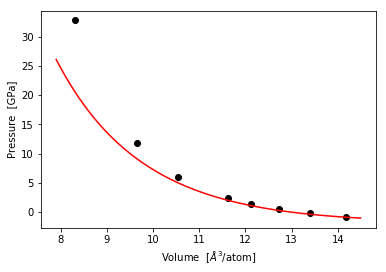

In [28]:
# Plot rough compress EOS as a Vinet model
kind_compress = 'Vinet'
compress_path_const = 'T'

eos_compress = models.CompressEos(kind=kind_compress, path_const='T')
eos_compress.set_param_values([V0,K0,KP0],['V0','K0','KP0'])

Vmod = V0*np.linspace(.6,1.1,1001)

plt.figure()
plt.plot(tbl_T0['V'],tbl_T0['P'],'ko')
plt.plot(Vmod, eos_compress.press(Vmod),'r-')
plt.xlabel(r'Volume  [$\AA^3$/atom]')
plt.ylabel(r'Pressure  [GPa]')

## Roughly fit average Gruneisen gamma value
* Use Mie-Gruneisen linear relation between thermal energy and pressure to determine average numerical gamma value
* Roughly fit Finite Strain Gamma model that captures the overall trend

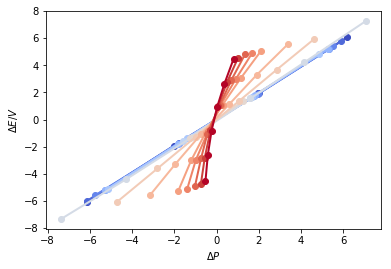

In [29]:
plt.figure()
Vuniq = np.unique(tbl['V'])
gamma_num = np.zeros(Vuniq.size)
cmap = plt.get_cmap('coolwarm',len(Vuniq))

for ind, iV in enumerate(Vuniq):
    imask = (tbl['V']==Vuniq[ind])
    iE_V = models.CONSTS['PV_ratio']*tbl['E'][imask]/iV
    iP = tbl['P'][imask]
    ipoly = np.polyfit(iP,iE_V,1)
    plt.plot(iP-np.mean(iP),iE_V-np.mean(iE_V),'o-',
             color=cmap(ind/len(Vuniq)), lw=2)
    plt.xlabel(r'$\Delta P$')
    plt.ylabel(r'$\Delta E / V$')
    gamma_num[ind] = 1/ipoly[0]
    

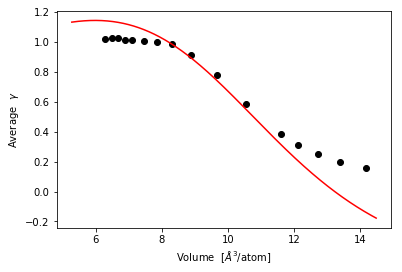

In [30]:
# Construct a rough model of average gamma values by hand tuning
kind_gamma = 'GammaFiniteStrain'
gamma0 = 0.01
gammap0 = -2.2
eos_gamma = models.GammaEos(kind=kind_gamma)
eos_gamma.set_param_values([V0,gamma0,gammap0],['V0','gamma0','gammap0'])

Vmod = V0*np.linspace(.4,1.1,1001)

plt.plot(Vuniq, gamma_num,'ko')
plt.plot(Vmod, eos_gamma.gamma(Vmod), 'r-')
plt.xlabel(r'Volume  [$\AA^3$/atom]')
plt.ylabel(r'Average  $\gamma$')

## Extract Constant-Volume Heat Capacity trends
* Extract constant-volume trends and fit Rosenfeld-Tarazona model to each
* Describe volume-dependence of Rosenfeld-Tarazona coefficient

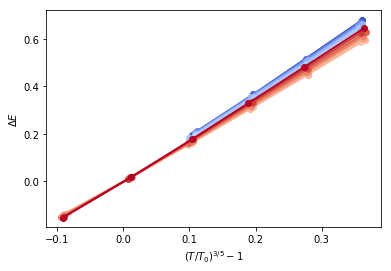

In [31]:
plt.figure()
Vuniq = np.unique(tbl['V'])
gamma_num = np.zeros(Vuniq.size)
cmap = plt.get_cmap('coolwarm',len(Vuniq))

mexp=3/5
bcoef_V = np.zeros(Vuniq.size)

for ind, iV in enumerate(Vuniq):
    imask = (tbl['V']==Vuniq[ind])
    iE = tbl['E'][imask]
    iT = tbl['T'][imask]
    itherm_perturb = (iT/T0)**mexp-1
    ipoly = np.polyfit(itherm_perturb,iE,1)
    plt.plot(itherm_perturb,iE-ipoly[1],'o-',
             color=cmap(ind/len(Vuniq)), lw=2)
    bcoef_V[ind] = ipoly[0]
    plt.xlabel(r'$(T/T_0)^{3/5}-1$')
    plt.ylabel(r'$\Delta E$')

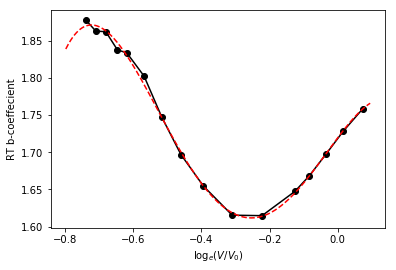

In [32]:
kind_RTpoly = 'logV'
RTpoly_order = 4
dlogV = np.log(Vuniq/V0)
bpoly = np.polyfit(dlogV, bcoef_V, RTpoly_order)
bcoefs = bpoly[::-1]

Vmod = V0*np.linspace(.45,1.1,1001)
dlogVmod = np.log(Vmod/V0)

plt.plot(dlogV, bcoef_V,'ko-')
plt.plot(dlogVmod, np.polyval(bpoly, dlogVmod),'r--')
plt.xlabel(r'$\log_e (V/V_0)$')
plt.ylabel('RT b-coeffecient')

In [33]:
print('b-coefficients = ', np.round(bcoefs,decimals=3))

b-coefficients =  [ 1.719  0.61  -0.586 -6.723 -6.008]


## Review Rough Initial EOS parameter guesses

In [34]:
Vmod = V0*np.linspace(.4,1.1,1001)

eos_mod = models.RTPressEos(kind_compress=kind_compress, 
                            compress_path_const=compress_path_const,
                            kind_gamma=kind_gamma, kind_RTpoly=kind_RTpoly, 
                            RTpoly_order=RTpoly_order, ref_energy_type='E0')
eos_mod.refstate.ref_state['T0'] = T0

bcoef_param_names = eos_mod.get_array_param_names('bcoef')

eos_mod.set_param_values([S0,V0,mexp],
                         param_names=['S0','V0','mexp'])
eos_mod.set_param_values([K0,KP0,E0], param_names=['K0','KP0','E0'])
eos_mod.set_param_values([gamma0,gammap0],
                         param_names=['gamma0','gammap0'])
eos_mod.set_param_values(bcoefs, param_names=bcoef_param_names)

params_init = eos_mod.get_params()

/Users/aswolf/Documents/projects/xmeos/xmeos/models/composite.py:1061: RuntimeWarning: divide by zero encountered in remainder
  if ((not np.isscalar(order)) | (order < 0) | (np.mod(order,0) !=0)):


In [35]:
analysis['params_init'] = params_init
analysis['eos_mod'] = eos_mod
with open(analysis_file, 'wb') as f:
    pickle.dump(analysis, f)

## View Rough Initial Guess for ALL data
* This is obviously not the best model, but it is at least in the neighborhood of a reasonable model
* This rough model will act as an initial guess for model fitting

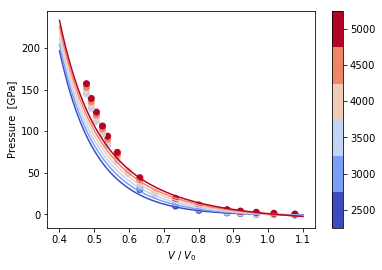

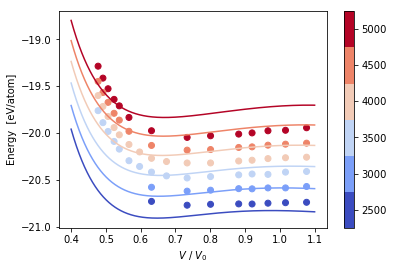

In [36]:
cmap = plt.get_cmap('coolwarm',len(Tlbl))
clims = [Tlbl[0]-delT/2,Tlbl[-1]+delT/2]


plt.figure()
for iT in Tlbl:
    icol = cmap((iT-clims[0])/(clims[1]-clims[0]))
    plt.plot(Vmod/V0, eos_mod.press(Vmod,iT), '-', color=icol)
    
plt.scatter(tbl['V']/V0,tbl['P'],c=tbl['T'], cmap=cmap)
plt.clim(clims)
plt.xlabel(r'$V$ / $V_0$')
plt.ylabel(r'Pressure  [GPa]')
cbar = plt.colorbar()
cbar.set_ticks(Tlbl)



plt.figure()
for iT in Tlbl:
    icol = cmap((iT-clims[0])/(clims[1]-clims[0]))
    plt.plot(Vmod/V0, eos_mod.internal_energy(Vmod,iT), '-', color=icol)
    
plt.scatter(tbl['V']/V0,tbl['E'],c=tbl['T'], cmap=cmap)
plt.xlabel(r'$V$ / $V_0$')
plt.ylabel(r'Energy  [eV/atom]')
plt.colorbar()
plt.clim(clims)
cbar.set_ticks(Tlbl)

